## Finding entity classes in embeddings

In this notebook we're going to use embeddings to find entity classes and how they correlate with other things

* SVM과 sklearn 잘 설명된 아티클 <br>
https://datascienceschool.net/view-notebook/6c6d450cb2ee49558856fd924b326e00/

### 임베딩에서 개체의 클래스 찾기 (2019. 03. 17)

In [12]:
%matplotlib inline
from IPython.core.pylabtools import figsize 
# "figsize" 에러나서 해당 코드 추가함

figsize(12, 8)

from sklearn import svm
from keras.utils import get_file
import os
import gensim
import numpy as np
import random
import requests
import geopandas as gpd 
# geopandas 설치 안되어 있다고 에러 나서 설치함
# pip install git+git://github.com/geopandas/geopandas.git
import subprocess
# "name 'subprocess' is not defined" 에러 나서 추가함
from IPython.core.pylabtools import figsize
import csv

as before, let's load up the model

In [13]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'], # 에러나서 import subprocess 추가함
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

Most similar to a bunch of countries are some other countries!

In [16]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

In [17]:
model.most_similar(positive=['Germany'])

[('Austria', 0.7461062073707581),
 ('German', 0.7178748846054077),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868600845337),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437496542930603),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.6342948079109192)]

In [18]:
model.most_similar(positive=['Annita_Kirsten'])

[('Braustolz_GmbH', 0.7545095682144165),
 ('DIARY_Economic_Indicators', 0.7334568500518799),
 ('##-##_#####_Burscheid', 0.7307888269424438),
 ('WKN_A#N#Y#_Symbol', 0.7260339260101318),
 ('Hoevelaken', 0.7067489624023438),
 ('BMW_###si_1min_##.###secs', 0.7050351500511169),
 ('Primera_EUROPE', 0.699741005897522),
 ('symbol_RSTI', 0.6925466656684875),
 ('Severin_Freund', 0.6898956894874573),
 ('However_Joern_Lauterjung', 0.688573956489563)]

No we'll create a training set with countries and non countries and get a support vector machine to learn the difference.

In [19]:
countries = list(csv.DictReader(open('data/countries.csv')))
countries[:10]
#국가 코드와 이름을 countries 변수에 넣음

[OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
 OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')]),
 OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
 OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
 OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')]),
 OrderedDict([('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')]),
 OrderedDict([('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')]),
 OrderedDict([('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')]),
 OrderedDict([('name', 'Netherlands'), ('cc', 'nl'), ('cc3', 'nld')]),
 OrderedDict([('name', 'East_Timor'), ('cc', 'tl'), ('cc3', 'tls')])]

In [20]:
positive = [x['name'] for x in random.sample(countries, 40)]
# countries 40개를 positive로 설정

negative = random.sample(model.vocab.keys(), 5000)
# 300만 개 vocab 중 5,000개를 negative로 지정

negative[:4]

['OYA', 'Gabriel_Faure', 'Rodriguez_Orejuela_brothers', 'quilt_appraiser']

In [21]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
# 국가(p)를 나타내는 레이블에는 '1'을 사용하고, 그 외 단어(n)에는 '0'을 사용함

random.shuffle(labelled)

X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
# 학습셋을 변수 X에 저장 / 변수 Y에 라벨 저장
# 국가라는 단어를 클래스로 정하고, 관련 단어들을 추출하는...

X.shape, y.shape

((5040, 300), (5040,))

###### SVC (Support Vector Classifier)

SVC를 사용하여 모형을 구하면 다음과 같은 속성값을 가진다.

- n_support_: 각 클래스의 서포트의 개수
- support_: 각 클래스의 서포트의 인덱스
- support_vectors_: 각 클래스의 서포트의 x 값.  𝑥+ 와  𝑥−
- coef_:  𝑤  벡터
- intercept_:  −𝑤0
- dual_coef_: 각 원소가  𝑎𝑖⋅𝑦𝑖 로 이루어진 벡터

In [22]:
TRAINING_FRACTION = 0.3
#학습셋과 검증셋 비율을 7:3으로 나눔

cut_off = int(TRAINING_FRACTION * len(labelled))

# SVC = Support Vector Classifier
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off]) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

We did alright, 99.9% precision:

##### 정밀도 (precision, TP / TP + FP) 계산

In [23]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(100.0, [])

In [24]:
all_predictions = clf.predict(model.syn0)

/Users/jihye/.pyenv/versions/anaconda3-2.2.0/envs/cookbook/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [12]:
# 모든 단어에 분류기(classifier)를 실행하여 국가를 추출

res = []
for word, pred in zip(model.index2word, all_predictions):
    if pred:
        res.append(word)
        if len(res) == 150:
            break
random.sample(res, 10)

['Guatemala',
 'Brazil',
 'Malawi',
 'Thailand',
 'Germany',
 'Algeria',
 'Venezuela',
 'Dominican_Republic',
 'Chile',
 'asylum']

In [13]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape

(184, 300)

### 3.5. 항목 내에서 시멘틱 거리 계산

Quick sanity check to see what is similar to Canada:

In [14]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(countries[idx]['name'], dists[idx])

Canada 7.5440235
New_Zealand 3.9619699
Finland 3.9392405
Puerto_Rico 3.8381448
Jamaica 3.8102937
Sweden 3.8042784
Slovakia 3.7038736
Australia 3.6711009
Bahamas 3.624042
United_States 3.5374334


### 3.6. 국가 데이터를 지도로 시각화하기

Ranking countries for a specific term:

In [15]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [16]:
rank_countries('cricket')

[('Sri_Lanka', 5.92276668548584),
 ('Zimbabwe', 5.336524963378906),
 ('Bangladesh', 5.1924896240234375),
 ('Pakistan', 4.948408126831055),
 ('Guyana', 3.9162840843200684),
 ('Barbados', 3.7579941749572754),
 ('India', 3.7504396438598633),
 ('South_Africa', 3.6561503410339355),
 ('New_Zealand', 3.642028570175171),
 ('Fiji', 3.608567714691162)]

Now let's visualize this on a world map:

In [17]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

pop_est      continent                  name iso_a3  gdp_md_est  \
0  28400000.0           Asia           Afghanistan    AFG     22270.0   
1  12799293.0         Africa                Angola    AGO    110300.0   
2   3639453.0         Europe               Albania    ALB     21810.0   
3   4798491.0           Asia  United Arab Emirates    ARE    184300.0   
4  40913584.0  South America             Argentina    ARG    573900.0   

                                            geometry  
0  POLYGON ((61.21081709172574 35.65007233330923,...  
1  (POLYGON ((16.32652835456705 -5.87747039146621...  
2  POLYGON ((20.59024743010491 41.85540416113361,...  
3  POLYGON ((51.57951867046327 24.24549713795111,...  
4  (POLYGON ((-65.50000000000003 -55.199999999999...

We can now plot some maps!

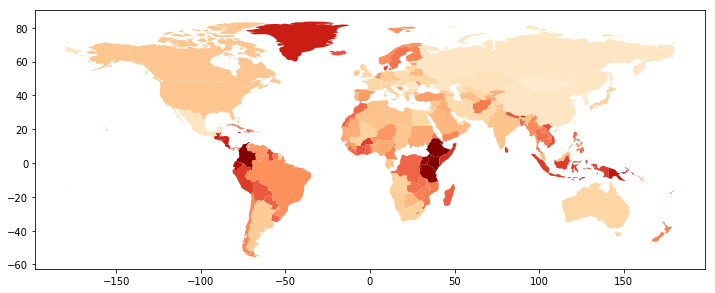

In [18]:
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

map_term('coffee')

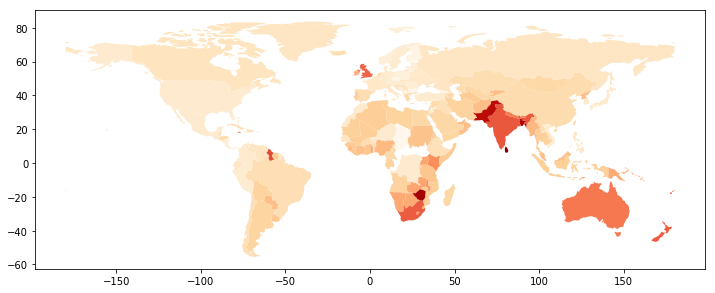

In [19]:
map_term('cricket')

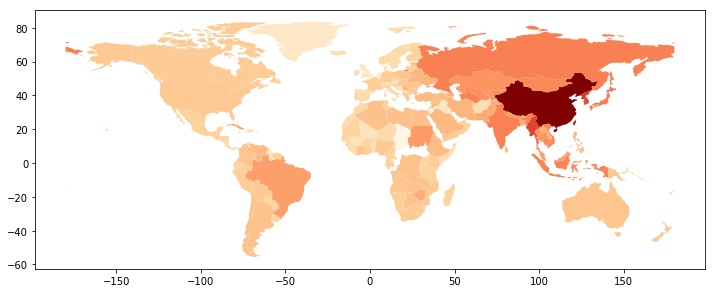

In [20]:
map_term('China')

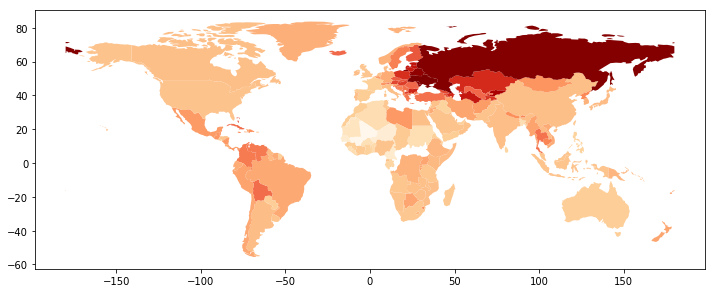

In [21]:
map_term('vodka')